In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

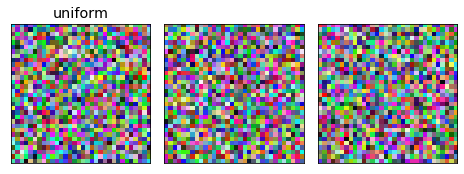

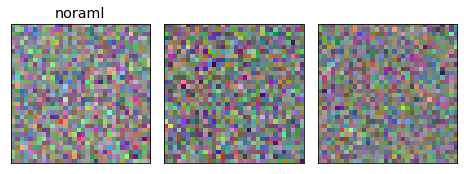

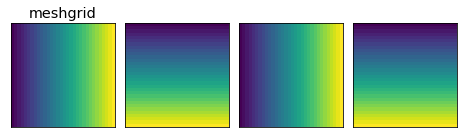

In [2]:
# Testing input generation
import utils
import input_gen as in_gen

# Uniform noise
imgs = []
uniform_noise = in_gen.get_noise(3, 32, 32, 'noise', 'uniform')
imgs.append(uniform_noise)
uniform_noise = in_gen.get_noise(3, 32, 32, 'noise', 'uniform')
imgs.append(uniform_noise)
uniform_noise = in_gen.get_noise(3, 32, 32, 'noise', 'uniform')
imgs.append(uniform_noise)
fig, axes = utils.tensors_as_images(imgs, titles=['uniform'])

# Normal noise
imgs = []
normal_noise = in_gen.get_noise(3, 32, 32, 'noise', 'normal')
imgs.append(normal_noise)
normal_noise = in_gen.get_noise(3, 32, 32, 'noise', 'normal')
imgs.append(normal_noise)
normal_noise = in_gen.get_noise(3, 32, 32, 'noise', 'normal')
imgs.append(normal_noise)
fig, axes = utils.tensors_as_images(imgs, titles=['noraml'])

# Meshgrid
imgs = []
meshgrid_input = in_gen.get_noise(3, 32, 32, 'meshgrid')
imgs.append(meshgrid_input[0].unsqueeze(dim=0))
imgs.append(meshgrid_input[1].unsqueeze(dim=0))
meshgrid_input = in_gen.get_noise(3, 32, 32, 'meshgrid')
imgs.append(meshgrid_input[0].unsqueeze(dim=0))
imgs.append(meshgrid_input[1].unsqueeze(dim=0))
fig, axes = utils.tensors_as_images(imgs, titles=['meshgrid'])



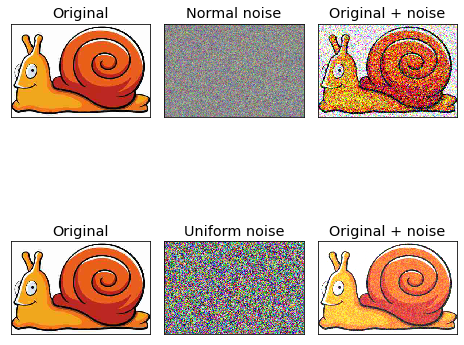

In [3]:
# Testing adding noise to image
from utils import *
from input_gen import add_noise_to_tensor
fname = 'data/denoising/snail.jpg'

img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np)
img_noisy_normal, normal_noise = add_noise_to_tensor(img_tr, 'normal', std=0.3)
img_noisy_uniform, uniform_noise = add_noise_to_tensor(img_tr, 'uniform', std=0.3)
fig, axes = utils.tensors_as_images([img_tr, normal_noise, img_noisy_normal, img_tr,
                                     uniform_noise, img_noisy_uniform], 
                                    titles=['Original', 'Normal noise', 'Original + noise',
                                            'Original', 'Uniform noise', 'Original + noise'], nrows=2,
                                   hspace=0)

In [4]:
from models import *
from models.unet import *

net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
          [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1], weight_std=1./30)
print(net)

UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): 

In [5]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 747803


In [7]:
net_input = img_tr.unsqueeze(dim=0)
parameters = [x for x in net.parameters()]
LR = 0.01
num_iter = 500
show_every = 50
optimizer = torch.optim.Adam(parameters, lr=LR)
for i in range(num_iter):
    optimizer.zero_grad()
    out = net(net_input)
    loss = mse(out, img_tr.unsqueeze(dim=0))
    loss.backward()
    optimizer.step()
    if i % show_every == 0:
        print(f'Iteration {i}   Loss = {loss.item()}')

Iteration 0   Loss = 0.026799146085977554
Iteration 5   Loss = 0.11519277840852737
Iteration 10   Loss = 0.07359600067138672
Iteration 15   Loss = 0.06794103235006332
Iteration 20   Loss = 0.06235165148973465
Iteration 25   Loss = 0.056301601231098175
Iteration 30   Loss = 0.051587291061878204
Iteration 35   Loss = 0.048096880316734314
Iteration 40   Loss = 0.04554108902812004
Iteration 45   Loss = 0.042492471635341644
Iteration 50   Loss = 0.040580689907073975
Iteration 55   Loss = 0.04021651670336723
Iteration 60   Loss = 0.03801805153489113
Iteration 65   Loss = 0.03612607344985008
Iteration 70   Loss = 0.03589487448334694
Iteration 75   Loss = 0.03630698099732399
Iteration 80   Loss = 0.03399907425045967
Iteration 85   Loss = 0.03244312107563019
Iteration 90   Loss = 0.03144050016999245
Iteration 95   Loss = 0.030356748029589653
Iteration 100   Loss = 0.032829649746418
Iteration 105   Loss = 0.028555048629641533
Iteration 110   Loss = 0.02824825793504715
Iteration 115   Loss = 0.02

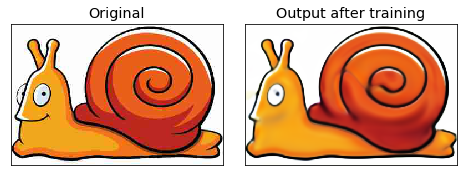

In [10]:
output = net(net_input).detach()
output = output.squeeze(dim=0)
fig, axes = utils.tensors_as_images([img_tr, output], 
                                    titles=['Original', 'Output after training'])